In [2]:
%load_ext autoreload
%autoreload 2

# Experimental 001

## Setup

In [3]:
from multiprocessing import process
from athena_analyze.data.processor import DataProcessor
from utils.logging import setup_logging
from utils.plotter import Plotter
from utils.config import load_config_section, load_config

_log = setup_logging()
data_cfg = load_config_section("../config/config.yml", "data")
processor = DataProcessor(data_fol=data_cfg["raw"])
dfs = []
dfs.append(processor.load_data("ETTh1.csv"))
dfs.append(processor.load_data("ETTh2.csv"))
plotter = Plotter("../reports/figures/exp_002")

exp_name = "exp_002"
general_cfg_path = "../config/config.yml"
exp_cfg_path = f"../config/{exp_name}.yml"

2026-02-07 01:29:55,259 - athena-assignment - DEBUG - DataProcessor initialized with data folder: ../data/raw
2026-02-07 01:29:55,299 - athena-assignment - DEBUG - Plotter initialized with output folder: ../reports/figures/exp_002


# Preprocess

MSTLを用いて周期性の分解を行う。

## EDA

exp_001のデータがどのような周期性を持っているかを確認する。

In [9]:
from anyio import Path
import pandas as pd
from athena_analyze.eda.analyzer import analyze_periodicity, compute_acf, compute_pacf
from athena_analyze.eda.visualize import plot_acf, plot_pacf, plot_power_spectrum
from pmdarima import pacf

train_df = processor.load_data(f"exp_002/train_h2.parquet", data_folder=Path("../data/experiment/"))
test_df = processor.load_data(f"exp_002/test_h2.parquet", data_folder=Path("../data/experiment/"))
plot_df = pd.concat([train_df, test_df])

cols = ["OT", "HUFL", "HULL", "MUFL", "MULL", "LUFL", "LULL"]
results = {}

for c in cols:
    _log.info(f"Analyzing column: {c}")
    periods_df, power_df = analyze_periodicity(plot_df, max_period=2500, fs=1, target_col=c)
    results[c] = {"periods" : periods_df, "power": power_df}
    acf_df = compute_acf(plot_df, target_col=c)
    pacf_df = compute_pacf(plot_df, target_col=c)
    results[c]["acf"] = acf_df
    results[c]["pacf"] = pacf_df

/home/yteramoto/dev/github/YHTR0257/athena-assignment/src/athena_analyze/data/processor.py:36: RuntimeWarning: coroutine 'Path.exists' was never awaited
  if not file_path.exists():
/home/yteramoto/dev/github/YHTR0257/athena-assignment/src/athena_analyze/data/processor.py:36: RuntimeWarning: coroutine 'Path.exists' was never awaited
  if not file_path.exists():


2026-02-07 08:55:47,481 - athena-assignment - INFO - Analyzing column: OT
2026-02-07 08:55:47,481 - athena-assignment - DEBUG - Analyzing periodicity for column: OT with fs=1 and max_period=2500 (data length: 17420)
2026-02-07 08:55:47,486 - athena-assignment - INFO - Detected 5 significant periods for OT
2026-02-07 08:55:47,487 - athena-assignment - DEBUG - Top period: 24.0 (relative power: 1.000)
2026-02-07 08:55:47,487 - athena-assignment - DEBUG - Computing ACF for column: OT with max_lag=8710 (data length: 17420)
2026-02-07 08:55:47,489 - athena-assignment - DEBUG - Computing PACF for column: OT with max_lag=1000 (data length: 17420)
2026-02-07 08:55:57,956 - athena-assignment - INFO - Analyzing column: HUFL
2026-02-07 08:55:57,956 - athena-assignment - DEBUG - Analyzing periodicity for column: HUFL with fs=1 and max_period=2500 (data length: 17420)
2026-02-07 08:55:57,961 - athena-assignment - INFO - Detected 5 significant periods for HUFL
2026-02-07 08:55:57,962 - athena-assignm

In [10]:
for col in cols:
    _log.info(f"Plotting results for column: {col}")
    acf_fig, _ = plot_acf(results[col]["acf"])
    pacf_fig, _ = plot_pacf(results[col]["pacf"])
    power_fig, _ = plot_power_spectrum(results[col]["power"])
    plotter.save_plot(acf_fig, f"h2_{col.lower()}_acf.png")
    plotter.save_plot(pacf_fig, f"h2_{col.lower()}_pacf.png")
    plotter.save_plot(power_fig, f"h2_{col.lower()}_power_spectrum.png")

2026-02-07 08:57:02,959 - athena-assignment - INFO - Plotting results for column: OT
2026-02-07 08:57:03,180 - athena-assignment - DEBUG - Plot saved to ../reports/figures/exp_002/h2_ot_acf.png
2026-02-07 08:57:03,240 - athena-assignment - DEBUG - Plot saved to ../reports/figures/exp_002/h2_ot_pacf.png
2026-02-07 08:57:03,372 - athena-assignment - DEBUG - Plot saved to ../reports/figures/exp_002/h2_ot_power_spectrum.png
2026-02-07 08:57:03,372 - athena-assignment - INFO - Plotting results for column: HUFL
2026-02-07 08:57:03,710 - athena-assignment - DEBUG - Plot saved to ../reports/figures/exp_002/h2_hufl_acf.png
2026-02-07 08:57:03,772 - athena-assignment - DEBUG - Plot saved to ../reports/figures/exp_002/h2_hufl_pacf.png
2026-02-07 08:57:03,904 - athena-assignment - DEBUG - Plot saved to ../reports/figures/exp_002/h2_hufl_power_spectrum.png
2026-02-07 08:57:03,904 - athena-assignment - INFO - Plotting results for column: HULL
2026-02-07 08:57:04,122 - athena-assignment - DEBUG - Plo

In [ ]:
from pathlib import Path
pp_general_cfg = load_config_section(general_cfg_path, "preprocess")
pp_exp_cfg = load_config_section(exp_cfg_path, "preprocess")

train_dfs = []
test_dfs = []

if Path(f"../data/experiment/{exp_name}/train_h1.parquet").exists() == True:
    _log.warning(f"Experiment folder ../data/experiment/{exp_name} already exists.")
    for name in ["train_h1", "train_h2", "test_h1", "test_h2"]:
        _log.info(f"Loading dataset {name}")
        df = processor.load_data(f"{exp_name}/{name}.parquet",
                                 data_folder=Path("../data/experiment"))
        if "train" in name:
            train_dfs.append(df)
        else:
            test_dfs.append(df)
else:
    for i, df in enumerate(dfs):
        _log.info(f"Processing dataset {i}")
        pp_cfg = dict(**pp_general_cfg, **pp_exp_cfg[f"h{i+1}"])
        train_df, test_df = processor.preprocess_data(df, **pp_cfg)
        train_dfs.append(train_df)
        test_dfs.append(test_df)

    from utils.data_io import save_dataframe_to_parquet
    data_cfg = load_config_section("../config/config.yml", "data")

    for df, name in zip(train_dfs + test_dfs, ["train_h1", "train_h2", "test_h1", "test_h2"]):
        save_dataframe_to_parquet(df, f"{exp_name}/{name}.parquet", config=data_cfg)

2026-02-05 16:38:52,969 - athena-assignment - WARNING - Experiment folder ../data/experiment/exp_001 already exists.
2026-02-05 16:38:52,970 - athena-assignment - INFO - Loading dataset train_h1
2026-02-05 16:38:53,258 - athena-assignment - INFO - Loading dataset train_h2
2026-02-05 16:38:53,278 - athena-assignment - INFO - Loading dataset test_h1
2026-02-05 16:38:53,291 - athena-assignment - INFO - Loading dataset test_h2


2026-02-05 16:38:53,475 - athena-assignment - DEBUG - Plotting time series for columns: ['OT', 'stl_OT_seasonal_24', 'stl_OT_seasonal_2160', 'stl_OT_resid', 'stl_OT_trend'] with date column: date


/tmp/ipykernel_3884236/1118345557.py:13: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


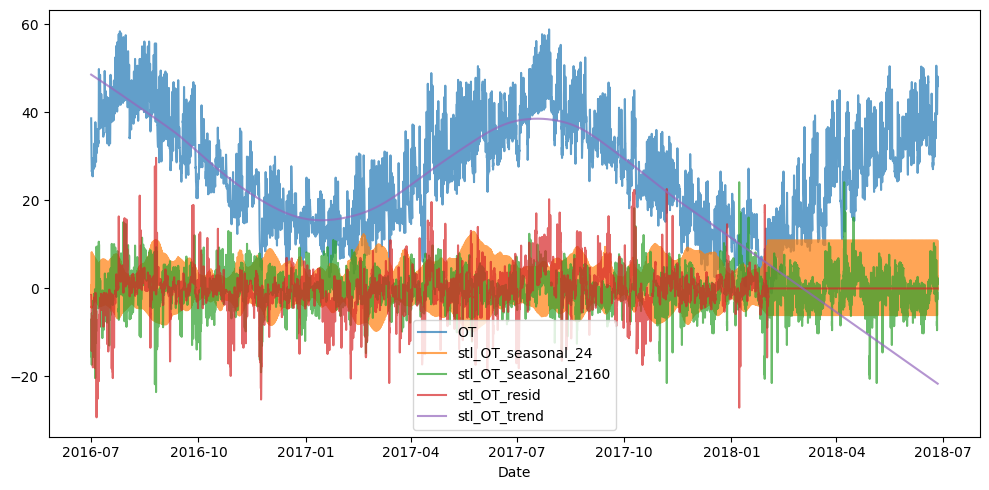

In [ ]:
from athena_analyze.eda.visualize import plot_time_series
import pandas as pd

plot_df = pd.concat(
    [
        train_dfs[1],
        test_dfs[1],
    ]
)
fig = plot_time_series(df=plot_df, date_col="date",
                       value_cols=["OT", "stl_OT_seasonal_24",
                                   "stl_OT_seasonal_2160", "stl_OT_resid", "stl_OT_trend"])
fig.show()

## Model Training

LightGBMモデルをOptunaによるハイパーパラメータチューニングで学習する。

In [ ]:
from athena_analyze.models.base import ModelRegistry

model_cfg = load_config_section(exp_cfg_path, "models")

registry = ModelRegistry()
registry.auto_discover()
registry.list_models()

each_model_cfg = [k for k in model_cfg.keys() if k in model_cfg["general"]["models"]]
trained_models = []

for model_name, each_cfg in zip(model_cfg["general"]["models"], each_model_cfg):
    print(f"Training model: {each_cfg}")
    model_cls = registry.get_model(model_name)
    model = model_cls(config=model_cfg[each_cfg])

    target_col = model_cfg[each_cfg].get("target_col", "OT")
    drop_cols = [target_col, "date"]
    feature_cols = [c for c in train_dfs[1].columns if c not in drop_cols]

    X_train = train_dfs[1][feature_cols]
    y_train = train_dfs[1][target_col]
    X_valid = test_dfs[1][feature_cols]
    y_valid = test_dfs[1][target_col]

    model.train(X_train, y_train, valid_data=X_valid, valid_label=y_valid)
    trained_models.append((each_cfg, model))

print("Training complete.")

2026-02-05 16:38:54,442 - athena-assignment - DEBUG - Auto-discovering models in directory: /home/yteramoto/dev/github/YHTR0257/athena-assignment/src/athena_analyze/models
2026-02-05 16:38:54,571 - athena-assignment - INFO - Registering model 'light_gbm' with class LightGBM
2026-02-05 16:38:54,870 - athena-assignment - INFO - Registering model 'sarima' with class SarimaModel
Training model: sarima


TypeError: SarimaModel.train() got an unexpected keyword argument 'valid_data'

## Model Params

学習させたモデルのパラメータを読み込みする。

In [ ]:
from pathlib import Path

models_dir = Path(f"../models/{exp_name}")
models_dir.mkdir(parents=True, exist_ok=True)

for name, model in trained_models:
    save_path = str(models_dir / f"{name}.txt")
    model.save_model(save_path)
    info = model.get_info()
    print(f"--- {name} ---")
    print(f"Model Type: {info['model_type']}")
    print(f"Num Trees: {info.get('num_trees')}")
    if info.get('best_params'):
        print(f"Best Params: {info['best_params']}")
    if info.get('optuna_best_value'):
        print(f"Optuna Best RMSE: {info['optuna_best_value']:.4f}")
    print(f"Saved to: {save_path}")
    print()

2026-02-05 14:34:33,568 - athena-assignment - INFO - Model saved to ../models/exp_001/light_gbm.txt
--- light_gbm ---
Model Type: LightGBM
Num Trees: 40
Best Params: {'learning_rate': 0.10189931591540446, 'num_leaves': 73, 'bagging_fraction': 0.7016209362897721, 'min_child_samples': 93, 'bagging_freq': 4, 'feature_fraction': 0.9539903286065194}
Optuna Best RMSE: 0.7904
Saved to: ../models/exp_001/light_gbm.txt



## Evaluation

モデルの評価を行う。
- MAPE, RMSE, MAE, R2

In [ ]:
for name, model in trained_models:
    target_col = model_cfg[name].get("target_col", "OT")
    drop_cols = [target_col, "date"]
    feature_cols = [c for c in test_dfs[1].columns if c not in drop_cols]

    X_test = test_dfs[1][feature_cols]
    y_test = test_dfs[1][target_col]

    eval_result = model.evaluate(X_test, y_test)
    print(f"--- {name} ---")
    for metric, value in eval_result.items():
        print(f"  {metric}: {value:.4f}")

--- light_gbm ---
  mape: 13.6580
  rmse: 0.9273
  mae: 0.7493
  r2: 0.9925
